In [16]:
# ⚙️ 프로젝트 환경 설정을 위한 첫 단계입니다.
# 필요한 라이브러리를 가져오고, 노트북의 기본적인 동작 방식을 설정합니다.

import os

from dotenv import load_dotenv

# .env 파일에서 환경 변수를 불러옵니다.
# 🕵️‍♂️ 이 기능 덕분에 API 키와 같은 민감한 정보를 코드에 직접 적지 않고도 안전하게 사용할 수 있어요.
# override=True는 이미 설정된 환경 변수가 있어도 .env 파일의 값으로 덮어쓰겠다는 의미입니다.
load_dotenv(os.path.join("..", ".env"), override=True)

# Jupyter Notebook의 자동 리로드 기능을 활성화합니다.
# 🔄 이 설정을 해두면 외부 파이썬 파일(.py)을 수정했을 때,
# 노트북 커널을 재시작하지 않아도 변경사항이 바로바로 반영되어 개발이 아주 편해져요!
# %load_ext autoreload는 autoreload 확장 기능을 불러오는 명령어입니다.
%load_ext autoreload
# %autoreload 2는 코드를 실행할 때마다 모든 모듈을 자동으로 리로드하도록 설정합니다.
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 컨텍스트 격리: 하위 에이전트

<img src="./assets/agent_header_subagent.png" width="800" style="display:block; margin-left:0;">

대화가 진행됨에 따라 에이전트 컨텍스트는 빠르게 증가할 수 있으며, 이는 여러 가지 긴 컨텍스트 관련 문제를 야기합니다. 주요 문제점은 동일한 컨텍스트 창 내에서 혼합된 목표가 최적의 성능을 저해할 수 있는 컨텍스트 충돌 또는 혼란입니다. [컨텍스트 격리](https://blog.langchain.com/context-engineering-for-agents/)는 [전문 하위 에이전트](https://www.anthropic.com/engineering/multi-agent-research-system)에 작업을 위임하여 효과적인 솔루션을 제공하며, 각 하위 에이전트는 자체 격리된 컨텍스트 창 내에서 작동합니다. 이 접근 방식은 컨텍스트 충돌, 혼란, 오염 및 희석을 방지하는 동시에 집중적이고 전문화된 작업 실행을 가능하게 합니다.



### 하위 에이전트 위임
![./assets/subagents.png](./assets/subagents.png)
주요 통찰은 특정 작업에 맞춰진 다양한 도구 세트를 가진 하위 에이전트를 생성할 수 있다는 것입니다. 각 하위 에이전트는 `subagent_type`을 키로 하는 레지스트리 사전에 저장되어, 메인 에이전트가 `task(description, subagent_type)` 도구 호출을 통해 작업을 위임할 수 있습니다. 하위 에이전트는 부모의 컨텍스트와 완전히 분리되어 작동하며, 그 결과는 `ToolMessage`로 부모 에이전트에 반환되어 관심사의 깔끔한 분리를 유지합니다.

## 단계 1: 하위 에이전트 생성

사용자가 하위 에이전트를 지정하는 방법을 정의해봅시다.
```python
from typing_extensions import TypedDict

class SubAgent(TypedDict):
    """전문화된 하위 에이전트를 위한 구성."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]
```

우리는 이러한 객체의 목록을 사용하여 액세스할 수 있는 모든 하위 에이전트를 생성합니다.

```python
agents: list[SubAgent] = ...
subagents = {
    agent['name']: create_react_agent(
        model=model,
        prompt=agent['prompt'],
        tools = get_tools(agent['tools']),
        ...
    )
}
```

## 단계 2: 하위 에이전트를 사용하는 도구 생성

논리적으로는 다음과 같아야 합니다:

```python
def task(
    description: str  # 하위 에이전트가 수행해야 할 작업
    subagent_type: str  # 사용할 하위 에이전트
):
    # 하위 에이전트에 전달할 새 메시지 생성 - 설명만 있어야 함
    # 하위 에이전트 호출
    # 상태를 하위 에이전트의 응답과 파일 시스템의 모든 변경 사항으로 업데이트
```

최종적으로는 다음과 같이 됩니다:

```python
@tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
def task(
    description: str,
    subagent_type: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
):
    """작업을 격리된 컨텍스트를 가진 전문화된 하위 에이전트에게 위임합니다.

    이는 작업 설명만 포함하는 하위 에이전트를 위한 신선한 컨텍스트를 생성하여
    부모 에이전트의 대화 기록으로부터의 컨텍스트 오염을 방지합니다.
    """
    # 요청된 에이전트 타입이 존재하는지 검증
    if subagent_type not in agents:
        return f"오류: {subagent_type} 타입의 에이전트를 호출했습니다. 허용된 타입은 {[f'`{k}`' for k in agents]}입니다."

    # 요청된 하위 에이전트 가져오기
    sub_agent = agents[subagent_type]

    # 작업 설명만 포함하는 격리된 컨텍스트 생성
    # 이것이 컨텍스트 격리의 핵심 - 부모 기록 없음
    state["messages"] = [{"role": "user", "content": description}]

    # 격리된 상태에서 하위 에이전트 실행
    result = sub_agent.invoke(state)

    # 명령 상태 업데이트를 통해 부모 에이전트에 결과 반환
    return Command(
        update={
            "files": result.get("files", {}),  # 파일 변경 사항 병합
            "messages": [
                # 하위 에이전트 결과가 부모 컨텍스트의 ToolMessage가 됨
                ToolMessage(
                    result["messages"][-1].content, tool_call_id=tool_call_id
                )
            ],
        }
    )

return task
```

In [17]:
%%writefile ../src/deep_agents_from_scratch/task_tool.py
"""하위 에이전트를 통한 컨텍스트 격리를 위한 작업 위임 도구입니다.

이 모듈은 격리된 컨텍스트를 가진 하위 에이전트를 생성하고 관리하기 위한
핵심 인프라를 제공합니다. 하위 에이전트는 특정 작업 설명만 포함하는
깨끗한 컨텍스트 창에서 작동하여 컨텍스트 충돌을 방지합니다.
"""

from typing import Annotated, NotRequired
from typing_extensions import TypedDict

from langchain_core.messages import ToolMessage
from langchain_core.tools import BaseTool, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.types import Command

from deep_agents_from_scratch.prompts import TASK_DESCRIPTION_PREFIX
from deep_agents_from_scratch.state import DeepAgentState


class SubAgent(TypedDict):
	"""전문화된 하위 에이전트를 위한 구성입니다."""

	name: str
	description: str
	prompt: str
	tools: NotRequired[list[str]]


def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
	"""하위 에이전트를 통해 컨텍스트 격리를 가능하게 하는 작업 위임 도구를 생성합니다.

	이 함수는 복잡한 다단계 작업에서 컨텍스트 충돌과 혼란을 방지하기 위해
	격리된 컨텍스트를 가진 전문화된 하위 에이전트를 생성하는 핵심 패턴을 구현합니다.

	Args:
		tools: 하위 에이전트에 할당할 수 있는 사용 가능한 도구 목록입니다.
		subagents: 전문화된 하위 에이전트 구성 목록입니다.
		model: 모든 에이전트에 사용할 언어 모델입니다.
		state_schema: 상태 스키마 (일반적으로 DeepAgentState) 입니다.

	Returns:
		전문화된 하위 에이전트에게 작업을 위임할 수 있는 'task' 도구를 반환합니다.
	"""
	# 🤖 에이전트 레지스트리를 생성합니다. 여기에 생성된 하위 에이전트들을 보관할 거예요.
	agents = {}

	# 🛠️ 선택적 도구 할당을 위해 도구 이름 매핑을 구축합니다.
	tools_by_name = {}
	for tool_ in tools:
		if not isinstance(tool_, BaseTool):
			tool_ = tool(tool_)
		tools_by_name[tool_.name] = tool_

	# ✨ 구성을 기반으로 전문화된 하위 에이전트를 생성합니다.
	for _agent in subagents:
		if "tools" in _agent:
			# ✍️ 만약 특정 도구가 명시되었다면, 해당 도구만 사용하도록 설정해요.
			_tools = [tools_by_name[t] for t in _agent["tools"]]
		else:
			# 🌐 지정되지 않았다면, 사용 가능한 모든 도구를 기본으로 사용합니다.
			_tools = tools
		agents[_agent["name"]] = create_react_agent(
			model, prompt=_agent["prompt"], tools=_tools, state_schema=state_schema
		)

	# 📝 도구 설명에 사용될 사용 가능한 하위 에이전트 목록을 생성합니다.
	other_agents_string = [
		f"- {_agent['name']}: {_agent['description']}" for _agent in subagents
	]

	@tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
	def task(
		description: str,
		subagent_type: str,
		state: Annotated[DeepAgentState, InjectedState],
		tool_call_id: Annotated[str, InjectedToolCallId],
	):
		"""격리된 컨텍스트를 가진 전문화된 하위 에이전트에게 작업을 위임합니다.

		이는 하위 에이전트를 위해 작업 설명만 포함하는 새로운 컨텍스트를 생성하여,
		부모 에이전트의 대화 기록으로부터의 컨텍스트 오염을 방지합니다.
		"""
		# 🧐 요청된 에이전트 타입이 존재하는지 확인합니다.
		if subagent_type not in agents:
			return f"오류: {subagent_type} 타입의 에이전트를 호출했습니다. 허용된 타입은 {[f'`{k}`' for k in agents]}입니다."

		# 👉 요청된 하위 에이전트를 가져옵니다.
		sub_agent = agents[subagent_type]

		# 🎯 작업 설명만 포함하는 격리된 컨텍스트를 생성합니다.
		# 이것이 바로 컨텍스트 격리의 핵심입니다! 부모 에이전트의 기록은 포함되지 않아요.
		state["messages"] = [{"role": "user", "content": description}]

		# 🚀 격리된 상태에서 하위 에이전트를 실행합니다.
		result = sub_agent.invoke(state)

		# 📤 Command 상태 업데이트를 통해 부모 에이전트에게 결과를 반환합니다.
		return Command(
			update={
				"files": result.get("files", {}),  # 파일 변경 사항이 있다면 병합합니다.
				"messages": [
					# 하위 에이전트의 결과는 부모 컨텍스트에서 ToolMessage가 됩니다.
					ToolMessage(
						result["messages"][-1].content, tool_call_id=tool_call_id
					)
				],
			}
		)

	return task

Overwriting ../src/deep_agents_from_scratch/task_tool.py


이제 하위 에이전트를 도구로 생성할 루틴이 있습니다. 이제 특정 하위 에이전트를 정의하고 시스템이 `task` 도구로 이들을 호출하도록 할 수 있습니다.    
위의 `_create_task_tool`은 `SubAgent` 타입의 목록을 받습니다. 이 목록은 생성될 에이전트들의 설명을 포함합니다. 

```python
class SubAgent(TypedDict):
    """Configuration for a specialized sub-agent."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]


def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    """Create a task delegation tool that enables context isolation through sub-agents.

```
`SubAgent` 클래스는 하위 에이전트의 이중 역할을 만족하기 위해 필요한 고유 정보를 정의합니다. 하위 에이전트는 도구와 에이전트 모두로 작동합니다.  

- **도구로서**, 감독 에이전트에 자신의 능력과 호출 방법에 대한 정보를 제공합니다.  
- **에이전트로서**, 작업을 수행하는 방법을 설명하는 프롬프트와 해당 작업을 위한 도구 세트가 필요합니다.  

아래에서 연구 하위 에이전트를 생성합니다. 그 `description`은 감독 에이전트에 단일 작업이 이 하위 에이전트에게 위임되어야 함을 알립니다. `SIMPLE_RESEARCH_INSTRUCTIONS`는 하위 에이전트가 연구를 지시하는 데 사용하는 프롬프트입니다. 이 예제에서는 간략하지만, 범용 연구자의 경우 훨씬 더 상세할 수 있습니다. 하위 에이전트에는 연구 중에 사용할 `web_search` 도구도 제공됩니다.  

```python
# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}
```

Note that the sub-agent receives a specific task, along with the necessary tools to complete it. It operates in its own context, limited to the single task description. This [context-engineering](https://blog.langchain.com/context-engineering-for-agents/) approach ensures that the subagent’s working context remains free of context clashes, confusion, poisoning, and dilution.

감독 에이전트 프롬프트는 이제 이러한 하위 에이전트를 호출하고 사용하는 방법에 대한 설명을 포함해야 합니다. 아래에 표시됩니다. *사용 가능한 도구* 설명과 해당하는 경우 병렬 연구를 사용하는 지침을 주목하세요.

In [18]:
from utils import show_prompt

from deep_agents_from_scratch.prompts import SUBAGENT_USAGE_INSTRUCTIONS

show_prompt(SUBAGENT_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  Your role is to coordinate research by delegating specific research tasks to sub-agents.                       │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  1. **task(description, subagent_type)**: Delegate research tasks to specialized sub-agents                     │
│     - description: Clear, specific research question or task                                                    │
│     - subagent_type: Type of agent to use (e.g., "research-agent")                                              │
│  2. **think_tool(reflection)**: Reflect on the results of each delegated task and plan next steps.              │
│     - reflection: Your detailed reflection on the results of the task and next steps.                           │
│                                                                                                                 │
│  **PARALLEL RESEARCH**: When you identify multiple independent research directions, make multiple **task**      │
│  tool calls in a single response to enable parallel execution. Use at most {max_concurrent_research_units}      │
│  parallel agents per iteration.                                                                                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **Task Delegation Budgets** (Prevent excessive delegation):                                                    │
│  - **Bias towards focused research** - Use single agent for simple questions, multiple only when clearly        │
│  beneficial or when you have multiple independent research directions based on the user's request.              │
│  - **Stop when adequate** - Don't over-research; stop when you have sufficient information                      │
│  - **Limit iterations** - Stop after {max_researcher_iterations} task delegations if you haven't found          │
│  adequate sources                                                                                               │
│  </Hard Limits>                                                                                                 │
│                                                                                                                 │
│  <Scaling Rules>                                                                                                │
│  **Simple fact-finding, lists, and rankings** can use a single sub-agent:                                       │
│  - *Example*: "List the top 10 coffee shops in San Francisco" → Use 1 sub-agent, store in                       │
│  `findings_coffee_shops.md`                                                                                     │
│                                                                                                                 │
│  **Comparisons** can use a sub-agent for each element 

이제 감독자와 하위 에이전트가 있는 연구 시스템을 구축해봅시다. 이것은 조각들이 어떻게 함께 작동하는지를 시연하기 위해 사전 정의된 검색 결과가 있는 모의 버전입니다. 다음 강의에서는 완전한 연구 시스템을 구축할 것입니다.

E0000 00:00:1760679210.904842  541173 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


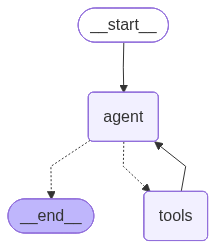

In [19]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

from deep_agents_from_scratch.prompts import SUBAGENT_USAGE_INSTRUCTIONS
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool

# 🎯 동시에 실행할 수 있는 최대 연구 단위와 연구원 에이전트의 최대 반복 횟수를 설정해요.
# 이 값들을 조절해서 에이전트의 행동을 제어할 수 있습니다.
max_concurrent_research_units = 3
max_researcher_iterations = 3

# 📚 모의 검색 결과를 미리 만들어 둡니다. 실제 웹 검색 대신 이 데이터를 사용할 거예요.
# 이렇게 하면 외부 API 호출 없이도 일관된 테스트가 가능하답니다.
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# 🌐 모의 검색 도구를 정의합니다. 이 도구는 `web_search`라는 이름으로 에이전트에게 제공돼요.
@tool(parse_docstring=True)
def web_search(
	query: str,
):
	"""특정 주제에 대한 정보를 웹에서 검색합니다.

	이 도구는 웹 검색을 수행하고 주어진 쿼리에 대한 관련 결과를 반환합니다.
	인터넷에서 어떤 주제에 대한 정보를 수집해야 할 때 사용하세요.

	Args:
		query: 검색 쿼리 문자열입니다. 찾고 있는 정보에 대해 구체적이고 명확하게 작성해주세요.

	Returns:
		검색 엔진의 검색 결과입니다.

	Example:
		web_search("헬스케어 분야의 머신러닝 적용 사례")
	"""
	return search_result


# 📝 모의 연구 지침을 추가합니다. 이 지침은 연구원 하위 에이전트가 어떻게 행동해야 할지 알려주는 프롬프트예요.
SIMPLE_RESEARCH_INSTRUCTIONS = """You are a researcher. Research the topic provided to you. IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the provided topic."""

# 🕵️‍♂️ 연구 하위 에이전트를 생성합니다. 이 에이전트는 연구 작업을 전문적으로 처리해요.
# 'name', 'description', 'prompt', 'tools'를 정의해서 어떤 역할을 하는지, 어떤 도구를 사용하는지 명시합니다.
research_sub_agent = {
	"name": "research-agent",
	"description": "하위 에이전트 연구원에게 연구를 위임합니다. 이 연구원에게는 한 번에 하나의 주제만 주세요.",
	"prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
	"tools": ["web_search"],
}

# 🧠 `create_react_agent`를 사용하여 직접 에이전트를 생성합니다.
# 사용할 모델과 온도를 설정합니다. 온도가 0이면 가장 결정적인 답변을 생성해요.
model = init_chat_model(model="google_genai:gemini-2.5-flash", temperature=0.0)

# 🔧 하위 에이전트가 사용할 도구 목록을 정의합니다. 여기서는 `web_search`만 사용해요.
sub_agent_tools = [web_search]

# ✨ `_create_task_tool` 함수를 호출하여 작업을 하위 에이전트에게 위임하는 'task' 도구를 생성합니다.
# 이 도구 덕분에 메인 에이전트가 "이 일은 네가 전문가니까 네가 해!"라며 작업을 맡길 수 있게 됩니다.
task_tool = _create_task_tool(
	sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

# 🛠️ 메인 에이전트(감독자)가 사용할 도구 목록입니다. 'task_tool'이 포함되어 있어 작업 위임이 가능해집니다.
delegation_tools = [task_tool]

# 🤖 시스템 프롬프트를 사용하여 에이전트를 생성합니다.
# 이 프롬프트는 에이전트의 역할, 사용 가능한 도구, 작동 방식 등을 상세하게 알려주는 설명서와 같아요.
agent = create_react_agent(
	model,
	delegation_tools,
	prompt=SUBAGENT_USAGE_INSTRUCTIONS.format(
		max_concurrent_research_units=max_concurrent_research_units,
		max_researcher_iterations=max_researcher_iterations,
		date=datetime.now().strftime("%a %b %-d, %Y"),
	),
	state_schema=DeepAgentState,
)

# 📊 에이전트의 구조를 시각적으로 확인해볼까요?
# `get_graph`를 사용하면 에이전트가 어떤 흐름으로 작동하는지 다이어그램으로 볼 수 있어요.
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [20]:
from utils import format_messages

result = agent.invoke(
	{
		"messages": [
			{
				"role": "user",
				"content": "Give me an overview of Model Context Protocol (MCP).",
			}
		],
	}
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "subagent_type": "research-agent",                                                                            │
│   "description": "Provide an overview of Model Context Protocol (MCP)."                                         │
│ }                                                                                                               │
│    ID: da212d2c-0d26-4874-b789-1e68f9b1ecdb                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Model Context Protocol (MCP)는 Anthropic이 개발한 개방형 표준 프로토콜입니다. 이 프로토콜은 AI 모델과 도구,     │
│ 데이터베이스, 기타 서비스와 같은 외부 시스템 간의 원활한 통합을 가능하게 합니다. MCP는 표준화된 통신 계층       │
│ 역할을 하여 AI 모델이 다양한 소스의 데이터를 일관되고 효율적인 방식으로 액세스하고 활용할 수 있도록 합니다.     │
│ 본질적으로 MCP는 데이터 교환을 위한 통합 언어를 제공함으로써 AI 비서와 외부 서비스를 연결하는 프로세스를        │
│ 단순화합니다.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Model Context Protocol (MCP)는 Anthropic이 개발한 개방형 표준 프로토콜입니다. 이 프로토콜은 AI 모델과 도구,     │
│ 데이터베이스, 기타 서비스와 같은 외부 시스템 간의 원활한 통합을 가능하게 합니다. MCP는 표준화된 통신 계층       │
│ 역할을 하여 AI 모델이 다양한 소스의 데이터를 일관되고 효율적인 방식으로 액세스하고 활용할 수 있도록 합니다.     │
│ 본질적으로 MCP는 데이터 교환을 위한 통합 언어를 제공함으로써 AI 비서와 외부 서비스를 연결하는 프로세스를        │
│ 단순화합니다.                                                                                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 
https://smith.langchain.com/public/26cc1c2b-e785-4c6d-a2a7-c30a31875fc7/r
<!-- https://smith.langchain.com/public/edc4e672-db9c-457a-953d-f62e7813591c/r -->